In [17]:
import pydicom
from os import listdir
import numpy as np
import matplotlib.pyplot as plt
import os
import pylibjpeg
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border
from skimage import measure
from skimage.measure import label,regionprops
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom
import plotly.graph_objects as go

skipped, no SliceLocation: 0
(512, 512, 36)


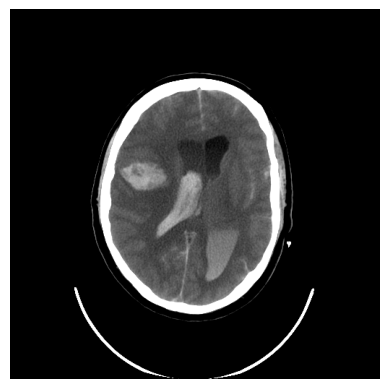

In [4]:
# Full path of the DICOM file is passed in base 
base = "unzipped_scans/CQ500CT1 CQ500CT1/Unknown Study"

loaded_files = []
for root, dirs, files in os.walk(base):
    if not dirs:
        for file in files:
            if file.lower().endswith(".dcm"):
                file_path = os.path.join(root, file)
                try:
                    dicom_file = pydicom.dcmread(file_path)
                    loaded_files.append(dicom_file)
                except Exception as e:
                    print(f"Error loading DICOM file {file_path}: {e}")

slope = dicom_file.RescaleSlope
intercept = dicom_file.RescaleIntercept

slices = []
skipcount = 0
for f in loaded_files:
    if hasattr(f, "SliceLocation"):
        slices.append(f)
    else:
        skipcount = skipcount + 1

print(f"skipped, no SliceLocation: {skipcount}")

# ensure they are in the correct order
slices = sorted(slices, key=lambda s: s.SliceLocation)


# create 3D array
img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

# fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s.pixel_array
    for j in range(img2d.shape[0]):
        for k in range(img2d.shape[1]):
            img2d[j][k] = slope*img2d[j][k] + intercept
            if(img2d[j][k]<0):
                img2d[j][k] = 0
            if img2d[j][k]>100:
                img2d[j][k] = 100
    img3d[:, :, i] = img2d

# plot 3 orthogonal slices
plt.imshow(img3d[:, :, 17], cmap='gray')
plt.axis("off")
print(img3d.shape)
plt.show()

# for i in range(img3d.shape[2]):
#     slice_path = os.path.join("Processed_sample", f"slice_{i:03d}.png")  # Zero-padded filenames
#     plt.imsave(slice_path, img3d[:, :, i], cmap='gray')


In [24]:
img = cv2.imread("Processed_sample/slice_017.png", cv2.IMREAD_UNCHANGED)
transposed_img = np.transpose(img3d, (2, 0, 1))

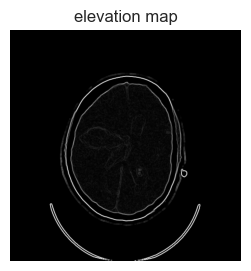

In [170]:
from skimage.filters import sobel
from skimage import exposure
im = img3d[:,:,19]
elevation_map = sobel(im)
fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(elevation_map, cmap=plt.cm.gray)
ax.set_title('elevation map')
ax.set_axis_off()

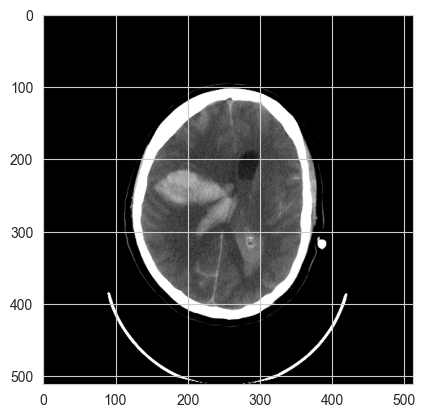

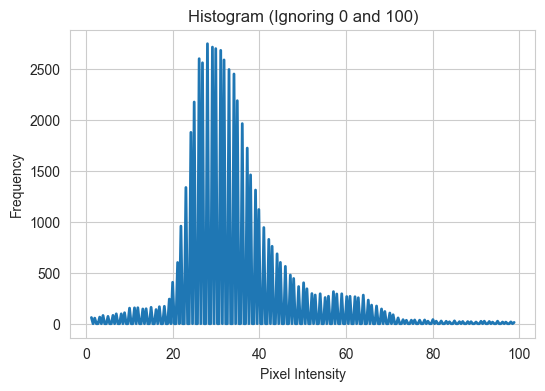

In [171]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.exposure import histogram

filtered_im = im[(im > 0) & (im < 100)]

# Compute the histogram
hist, hist_centers = histogram(filtered_im)

# Plot the histogram
plt.imshow(im, cmap=plt.cm.gray)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(hist_centers, hist, lw=2)
plt.title('Histogram (Ignoring 0 and 100)')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



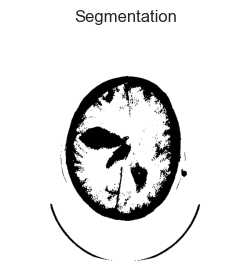

In [175]:
markers = np.zeros_like(im)
markers[im > 20] = 1
markers[im < 37] = 2

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(markers, cmap="gray")
ax.set_title('Segmentation')
ax.set_axis_off()